## Model-fitting

#### Imports

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [14]:
df = pd.read_csv("../data/processed/reddit_emotions_cleaned.csv")
df.head()

,clean_text,subreddit,emotional_score
0,husband doesnt pressure sex spent entire life ...,gratitude,1.0
1,getting sleep divorce comes sleep hygiene husb...,gratitude,1.0
2,get shopping hauls others like used partner di...,gratitude,1.0
3,first meal escaped homelessness able find chea...,gratitude,1.0
4,gratitude didnt fix life made quieter inside u...,gratitude,1.0


In [15]:
df.shape

(3621, 3)

Splitting data and fitting TF-IDF Vectorizer

In [16]:
X = df["clean_text"]
y = df["emotional_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

#### Model fitting (Ridge Regression)

In [18]:
ridge = Ridge()
ridge.fit(X_train_vec, y_train)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [19]:
y_pred = ridge.predict(X_test_vec)
y_pred = y_pred.clip(0.0, 1.0)

In [20]:
def print_scores(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

In [21]:
def plot_preds(y_test, y_pred):
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
    plt.xlabel("Actual Score")
    plt.ylabel("Predicted Score")
    plt.title("Predicted vs Actual Emotional Scores")
    plt.plot([0,1],[0,1], color='red')
    plt.show()

In [22]:
print_scores(y_test, y_pred)

MSE: 0.0475
MAE: 0.1696
R²: 0.5836


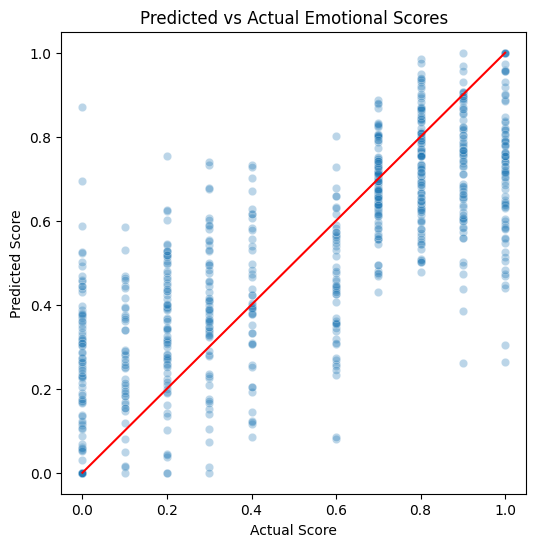

In [23]:
plot_preds(y_test, y_pred)

Model Fitting (Random Forest Regressor)

In [24]:
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train_vec, y_train)
y_pred_rfr = rfr.predict(X_test_vec)

In [25]:
print_scores(y_test, y_pred_rfr)

MSE: 0.0550
MAE: 0.1628
R²: 0.5177


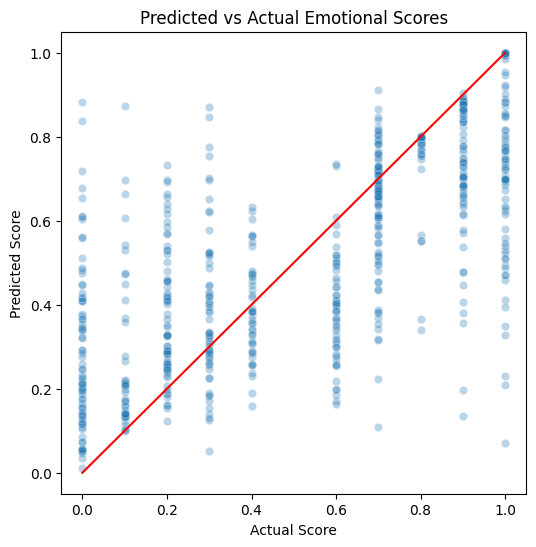

In [26]:
plot_preds(y_test, y_pred_rfr)


#### Hyperparameter Tuning

In [27]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    # 'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

In [28]:
grid_search = GridSearchCV(
    estimator=rfr,
    param_grid=param_grid,
    cv=2,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_vec, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], 'n_estimators': [100, 200]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,2
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [29]:
print("Best Params:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test_vec)
y_pred_tuned = y_pred_tuned.clip(0.0, 1.0)

Best Params: {'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [30]:
print_scores(y_test, y_pred_tuned)

MSE: 0.0542
MAE: 0.1617
R²: 0.5243


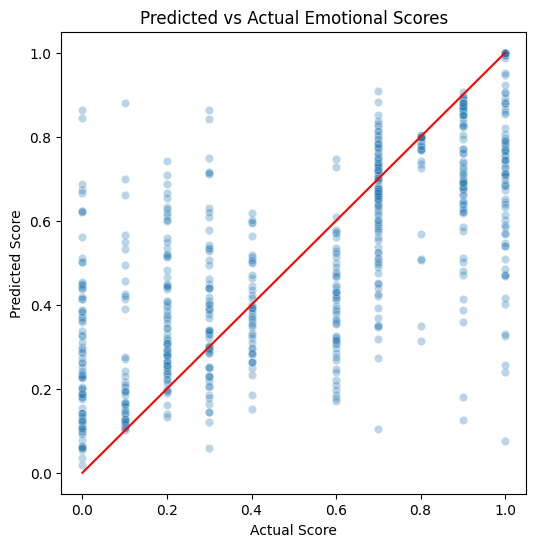

In [31]:
plot_preds(y_test, y_pred_tuned)

#### Saving Model

In [32]:
import pickle

with open("../models/rfr_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

with open("../models/vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)